# [NTDS'17] assignment 4: graph signal processing
[ntds'17]: https://github.com/mdeff/ntds_2017

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](http://lts2.epfl.ch)

In this assignment we'll use the [PyGSP](https://github.com/epfl-lts2/pygsp) to do some Graph Signal Processing (GSP). This fourth assignement is shorter than the last one in order to let you focus on your projects.

Done by - Prakhar Srivastava

In [1]:
%matplotlib inline

import numpy as np
from scipy import sparse, spatial
import pandas as pd
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting

plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'

If you get an import error about the PyGSP, install it with `pip install pygsp` or `conda install -c conda-forge pygsp`.

## 1 Data

For this assignment, we'll again use the [Free Music Archive dataset](https://github.com/mdeff/fma), as for the third. This time, I'm giving you all the data. Let's load the musical genres.

In [2]:
# Ground truth genres.
tracks = pd.read_csv('../data/fma_tracks.csv', index_col=0, squeeze=True)

# Complete missing genres.
tracks[:10] = [21, 21, 27, 12, 31, 89, 36, 25, 21, 12]

# Convert to top-level genres.
tracks = tracks.apply(lambda gid: 21 if gid in [21, 83, 100, 539, 542, 811] else 12)
assert set(tracks.unique()) == {12, 21} 

## 2 Graph

Given a data matrix $\mathbf{X} = [\mathbf{x}_1, \ldots, \mathbf{x}_N]^\intercal \in \mathbb{R}^{N \times d}$, where each $\mathbf{x} \in \mathbb{R}^d$ of the $N=2000$ row is a sample for which we have $d$ features, we constructed in the last assigment a similarity graph defined as
$$\mathbf{W}[i,j] = \exp(-d^2(\mathbf{x}_i - \mathbf{x}_j) / \sigma^2).$$

We construct below a PyGSP graph object with the edge weights from the last assignment.

In [3]:
weights = sparse.load_npz('../data/fma_graph.npz')
G = graphs.Graph(weights, gtype='FMA genres')
del weights

With the PyGSP, compute the normalized graph Laplacian, defined as
$$\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1/2} \mathbf{W} \mathbf{D}^{-1/2},$$
where $\mathbf{D} \in \mathbb{R}^{N \times N}$ is the diagonal degree matrix and $\mathbf{I}$ is the identity matrix.

Hints:
* Look at the documentation [here](https://pygsp.readthedocs.io/en/latest/reference/graphs.html).

In [4]:
# Your code here.
G.compute_laplacian(lap_type = 'normalized')
G.L

<2000x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 276988 stored elements in Compressed Sparse Row format>

## 3 Fourier basis

The PyGSP can compute the graph Fourier basis.

In [5]:
G.compute_fourier_basis(recompute=True)

The vector of eigenvalues are then available at `G.e`, and the Fourier basis, i.e., the eigenvectors, at `G.U`.

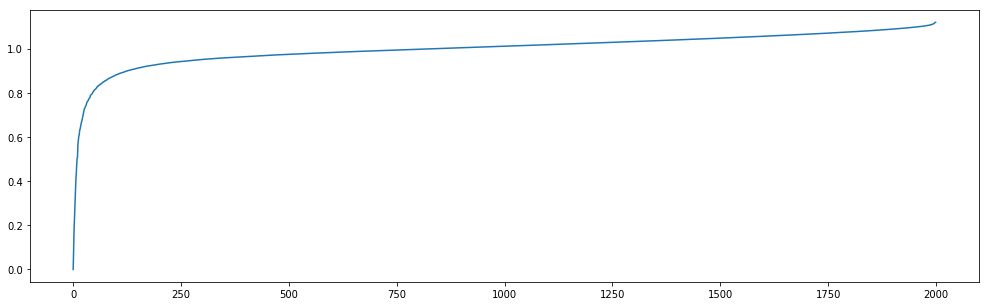

In [6]:
plt.plot(G.e);

From the above plot, can you infer if the Fourier basis was computed from a combinatorial or normalized Laplacian?

**Your answer here.** The eigenvalues $\{\lambda_t\}_{t=0,1,...,N-1}$ of the normalized graph laplacian of a connected graph $\mathcal G (N, \mathcal E)$ satisfy $$0 = \lambda_0 < \lambda_1 \leq ... \leq \lambda_{max} \leq 2,$$ with $\lambda_{max} = 2$ if and only if $\mathcal G$ is bipartite. Since the eigenvalues observed above lie between 0 and 2, hence it can be concluded that the fourier basis was computed from the normalized laplacian.

## 4 Layout

To visualize our graph, we need to give each node a coordinate in 2 or 3 dimensions. Embed the graph in 2D with Laplacian eigenmaps and visualize it.

Hints:
* Use `G.set_coordinates()` and `G.plot()`.

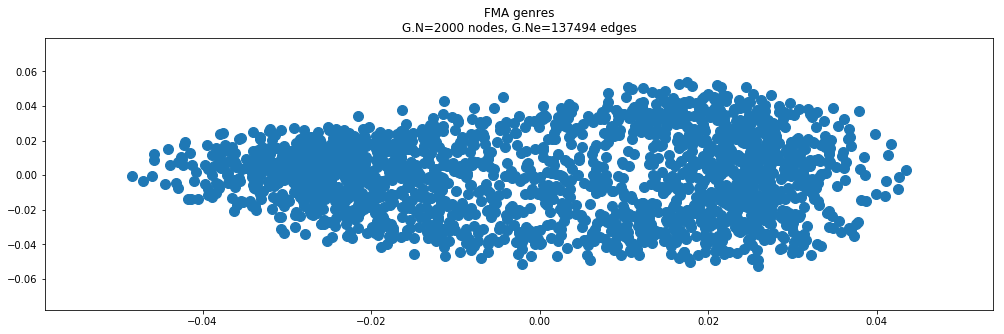

In [7]:
#Your code here.
coords = G.U[:, 1:3]
G.set_coordinates(kind = coords)
G.plot()

We can also visualize signals, like the genres.

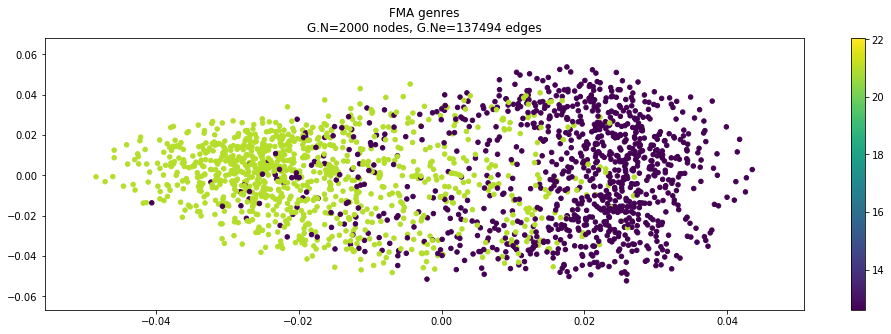

In [8]:
G.plot_signal(tracks, vertex_size=20)

Or the eigenvectors / Fourier modes.

Hint:
* If you did embed the graph correctly, you should see how the second and third eigenvectors are aligned with the x and y axes.

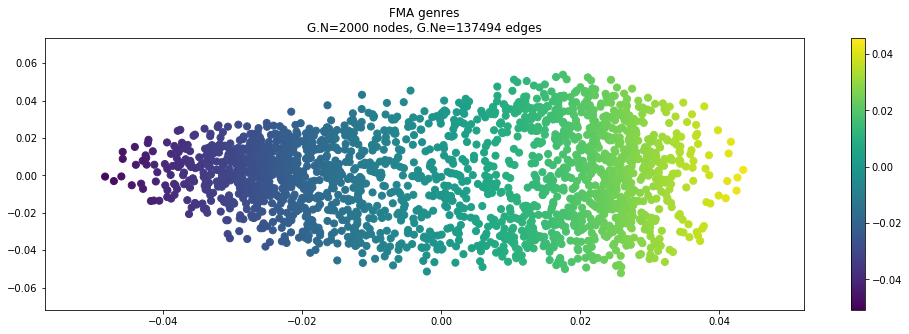

In [9]:
#Plotting the second eigenvector, seeing an variation along x-axis
G.plot_signal(G.U[:, 1], vertex_size=50)

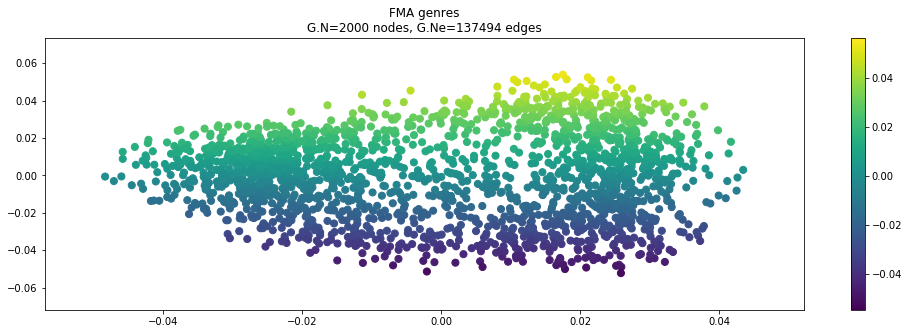

In [10]:
#Plotting the third eigenvector, seeing an variation along y-axis
G.plot_signal(G.U[:, 2], vertex_size=50)

## 5 Filter localization

We define below the low-pass filter
$$\hat{g}(x) = \exp \left( \frac{-\tau x}{\lambda_{\text{max}}} \right).$$
Its frequency response is depicted.

The vertical bars in the plot represents the eigenvalues of the graph. While the filter is continuous, it is only evaluated at those eigenvalues when filtering a graph signal.

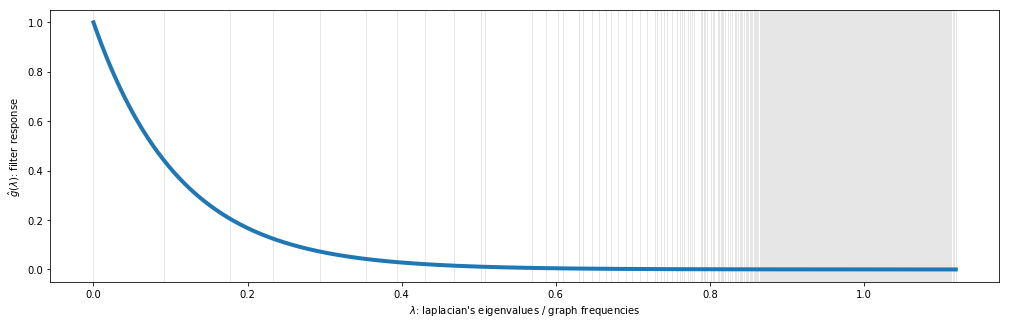

In [11]:
f = filters.Heat(G, tau=10)
f.plot()

To observe how our kernel looks like in the node domain, we would like to localize it on node $i$. Given the Fourier basis $\mathbf{U}$, the filter kernel $\hat{g}(\lambda)$, and the diagonal matrix of eigenvalues $\mathbf\Lambda$, what is the expression of the localized kernel $T_i g \in \mathbb{R}^N$?

**Your answer here.** A graph signal $x$ is filtered as $$y = U \hat g(\mathbf{\Lambda}) U^\intercal x \Rightarrow y = \hat g(U \mathbf{\Lambda} U^\intercal)x \Rightarrow y = \hat g(L)x,$$ where $\hat g(\cdot)$ is the filter kernel defined in the spectral domain as a function of the eigenvalues ("frequencies"). A kernel is localized at vertex $i$ by applying the corresponding filter to a Kronecker delta function $$\begin{split}g(L) s = g(L)_i, \text{ where } s_j = \delta_{ij} = \begin{cases} 0 \text{ if } i \neq j \\ 1 \text{ if } i = j    \end{cases}\end{split}$$

Now localize it at node $i=300$ and observe the result.

Hints:
* You can evaluate the filter with `f.evaluate()`.
* You can filter a signal with `f.filter()`.

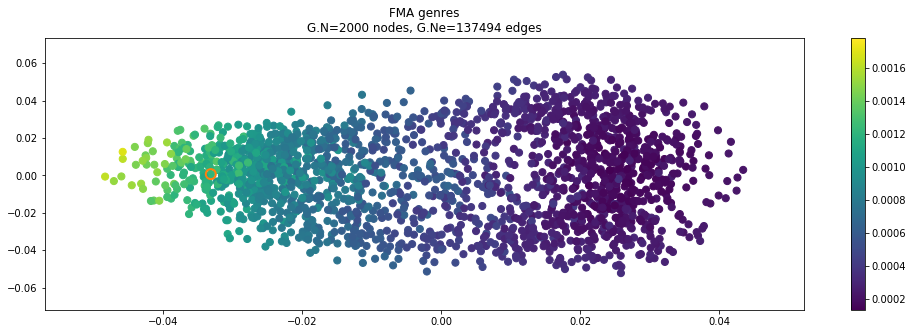

In [12]:
NODE = 300

#Direct way would be to simply use the f.localize() function

#Indirectly, we can explicitly apply the filter on delta function as shown below
x = np.zeros((2000,))
x[NODE] = 1
s = f.filter(x)

#Or, we could also use f.evaluate() to apply filter on eigenvalues, and then use g(L)*delta formulation to localize the filter. 

G.plot_signal(s, vertex_size=50, highlight=NODE)

Intuitively, should the plotted graph signal be smooth?

**Your answer here.** Yes, the plotted graph signal should be smooth. It is because, if we take a look at the filter response in the frequency domain, it is evident that it behaves like a low pass filter, attenuating all the high frequencies. Hence, in the vertex domain, that should mean that number of edges with sudden jumps in signal values should get reduced and we get a smooth signal since smooth signal corresponds to low frequency (sudden variations and zero crossings correspond to high frequency).

Delta function has a sudden jump at node 300, hence it is a high frequency signal. On filtering with low-pass filter, the high frequencies get attenuated and signal becomes low frequency in frequency domain, or, smooth in vertex domain.

Confirm your intuition by looking at the signal `s` in the Fourier domain. Compare with the graph Fourier transform (GFT) of a delta signal
$$\delta_i[j] =
\begin{cases}
1 & \text{if } j = i, \\
0 & \text{otherwise.}
\end{cases}$$

Hints:
* You can compute the GFT with `G.gft()`.

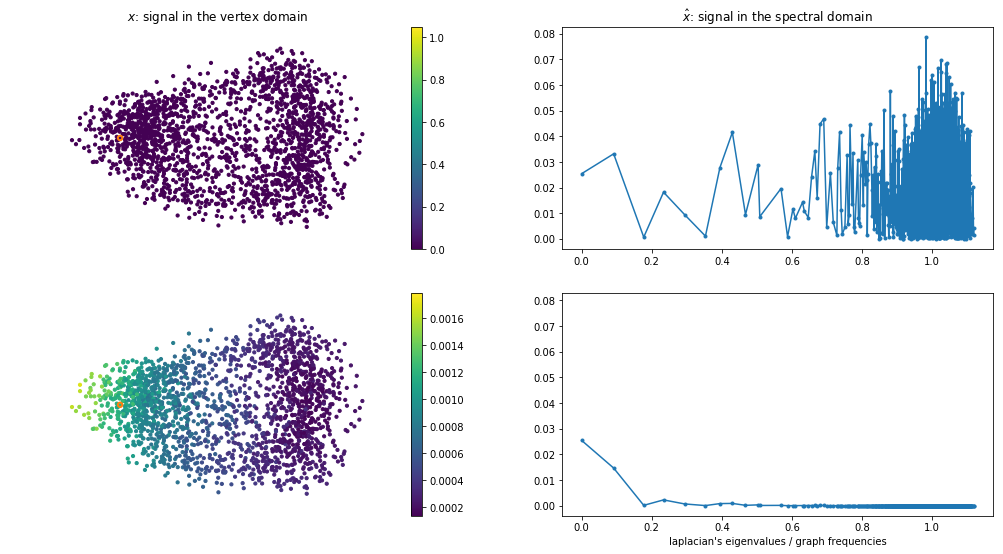

In [13]:
# Your code here.
y = f.filter(x)
signals = [x, y]
fig, axes = plt.subplots(len(signals), 2, figsize=(17, 9), sharey = 'col')
for i, s in enumerate(signals):
    s_hat = G.gft(s).squeeze()
    
    G.plot_signal(s, vertex_size = 10, highlight = NODE, ax = axes[i, 0])
    axes[i, 0].set_axis_off()
    axes[i, 0].set_title('')
    
    if i == 0:
        axes[0, 1].plot(G.e, np.abs(s_hat), '.-')
    else:
        axes[1, 1].plot(G.e, np.abs(s_hat), '.-')


axes[0, 0].set_title(r'$x$: signal in the vertex domain')
axes[0, 1].set_title(r'$\hat{x}$: signal in the spectral domain')
axes[-1, 1].set_xlabel("laplacian's eigenvalues / graph frequencies");

## 6 Transductive learning

In this problem, we'll consider having the labels for some percentage of our $N=2000$, but missing those of the other half. Those of you who have done some [Machine Learning (ML)](https://en.wikipedia.org/wiki/Machine_learning) will surely recognize here a [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning) problem and will say: yeah, let's train a classifier on the training data, and predict the missing labels! While they would not be wrong in doing so, they would not use the unlabeled data at all for training. The setup where test cases are known a-priori is called [transductive learning](https://en.wikipedia.org/wiki/Transduction_%28machine_learning%29). So let's exploit the structure of the data domain with similarity graph!

Define $\mathbf{y} \in \{-1,1\}^n, n < N,$ as the subset of known labels (the musical genres) and $M$ as a masking matrix indicating the observations, with $\operatorname{diag}(M) \in \{0,1\}^N$.

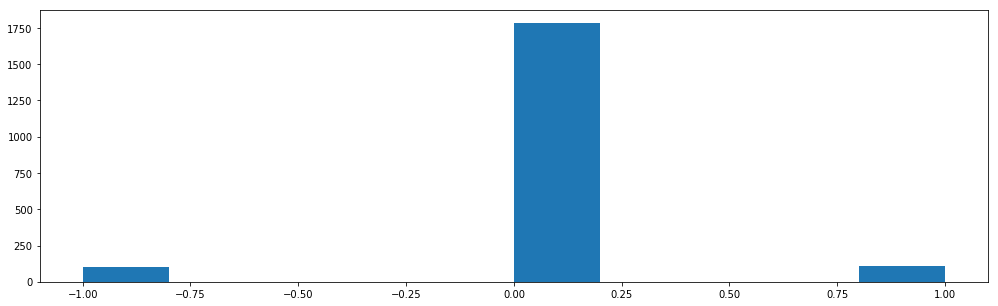

In [14]:
# Ground truth.
x = np.ones(G.N)
x[tracks.values == 21] = -1

def prepare_observations(p):
    """Prepare observations, where p is the percentage of values to keep."""
    rs = np.random.RandomState(42)
    M = np.diag(rs.uniform(size=G.N) < p)
    return M.dot(x)

# Play with the percentage of observed values.
y = prepare_observations(p=0.1)
plt.hist(y);

The problem we then want to solve is
$$\mathbf{x}^* = \operatorname*{arg\,min}_{\mathbf{x} \in \mathbb{R}^N} \|\mathbf{y} - \mathbf{Mx}\|_2^2 + \alpha \mathbf{x}^\intercal \mathbf{L} \mathbf{x},$$
where $\alpha$ is an hyper-parameter which controls the trade-off between the data fidelity term and the smoothness prior.

What is the solution of this problem?

**Your answer here.** Instead of an iterative method to compute the optimal $x$, we can directly compute the analytical solution. Since it is a minimization problem, we can simply find the optimal solution by equating the derivative to zero while ensuring that the Hessian is positive and that the formulation itself is convex (thereby ensuring a global minima). Our formulation is $$f(x) = \|y - Mx\|_2^2 + \alpha x^\intercal L x$$ which can also be written as $$\begin{eqnarray} f(x) &=& (y - Mx)^\intercal (y - Mx) + \alpha x^\intercal L x \nonumber \\ &=& y^\intercal y - y^\intercal Mx -x^\intercal M^\intercal y + x^\intercal M^\intercal Mx + \alpha x^\intercal Lx\end{eqnarray}$$ Differentiating with respect to x, we get $$f^{'}(x) = -2 M^\intercal y + 2M^\intercal Mx + 2\alpha Lx$$ As we know, solving $f^{'}(x) = 0$ will give us $x^*$, which means solving this particular linear equation : $$(M^\intercal M + \alpha L)x = M^\intercal y$$ Let's check whether the solution is indeed minimum or not. Calculating the hessian, $$f^{''}(x) = 2M^\intercal M +2 \alpha L^\intercal$$ we observe that it is a symmetric matrix (since both $L$ and $M$ are symmetric) and hence, positive semi-definite throughout. Hence, the optimum is a minimum and the formulation is convex, ensuring that it is globally minimum.

Implement it below.

Hints:
* The solution of a linear system of equations can be found with `np.linalg.solve()`.

In [15]:
def solve(y, alpha):
    """
    Solve the optimization problem.
    
    Parameters:
        y: the observations
        alpha: the balance between fidelity and smoothness prior.
    
    Returns:
        x_pred: the predicted class
        x_star: the solution of the optimization problem
    """
    M = np.diag(np.abs(y))
    A = M.T.dot(M) + alpha * G.L
    b = M.T.dot(y)
    x_star = np.linalg.solve(A, b)
    x_pred = x_star.copy()
    x_pred[x_star<0] = -1
    x_pred[x_star>=0] = 1
    # Your code here.

    return x_pred, x_star

x_pred, x_star = solve(y, alpha=1)

# Be sure that the prediction is binary.
np.testing.assert_equal(abs(x_pred), 1)

# Error rate.
err = np.count_nonzero(x - x_pred)
print('{} errors ({:.2%})'.format(err, err/G.N))

276 errors (13.80%)


Let's visualize the various graph signals:
1. The ground truth `x`.
1. The observations `y`.
1. The smooth solution `x_star`.
1. The binary prediction `x_pred`.

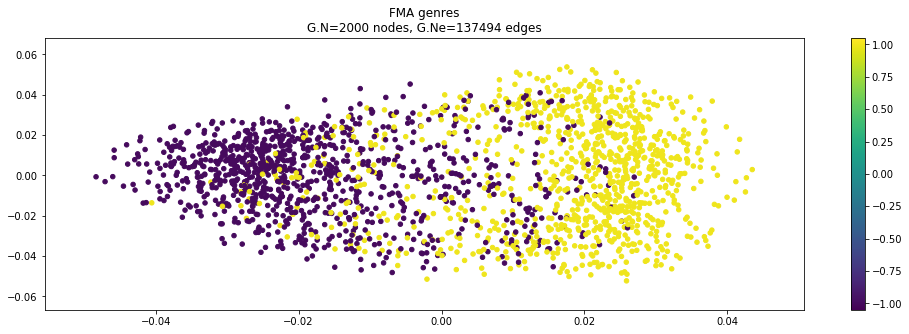

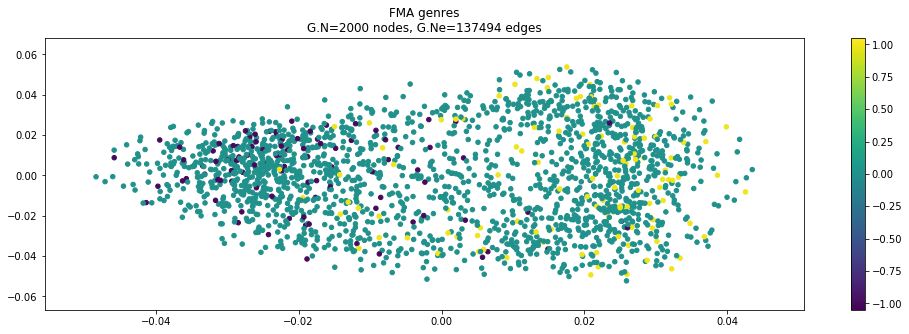

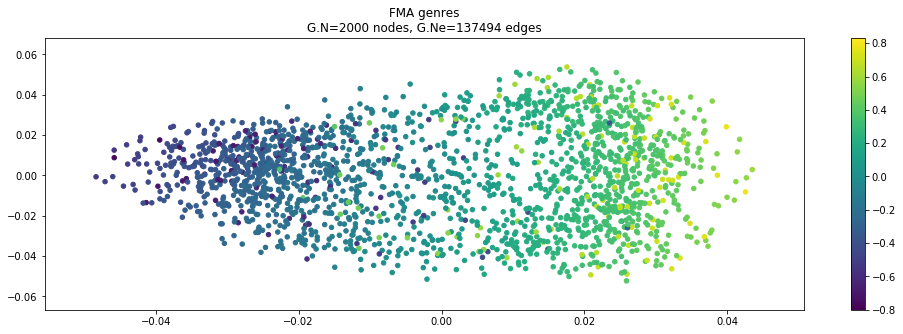

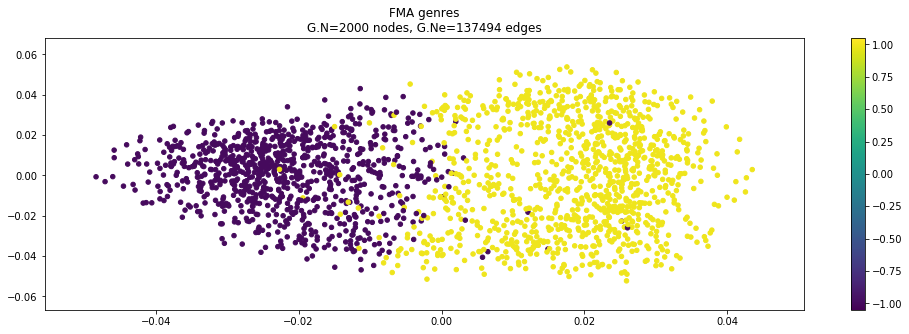

In [16]:
G.plot_signal(x, vertex_size=20)
G.plot_signal(y, vertex_size=20)
G.plot_signal(x_star, vertex_size=20)
G.plot_signal(x_pred, vertex_size=20)

Compute the prediction accuracy as a function of $p \approx \frac{n}{N}$.

In [17]:
alpha = 0.1

for p in [0.1, 0.3, 0.5, 0.7, 0.9]:
    # Your code here.
    y = prepare_observations(p=p)
    x_pred, x_star = solve(y, alpha=alpha)
    err = np.count_nonzero(x - x_pred)
    print('{}: {:6.2%}'.format(p, err/G.N))

0.1: 13.25%
0.3:  9.55%
0.5:  6.65%
0.7:  4.05%
0.9:  0.95%


## 7 Conclusion

In this assignment, you hopefully got some intuitions about the graph Fourier transform (GFT), and have an idea on how we can leverage graphs to exploit geometry in the data. Moreover, we saw that the [PyGSP](https://github.com/epfl-lts2/pygsp) can considerably ease Graph Signal Processing (GSP)!

If you feel confident about predicting genres on the [FMA](https://github.com/mdeff/fma), consider participating to our [genre recognition challenge](https://www.crowdai.org/challenges/www-2018-challenge-learning-to-recognize-musical-genre) to label 35,000 tracks! I will surely have a semester or master project to offer to those who do well. :)